# Prophet Python Baseline

In [784]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

In [785]:
# custom MAPE
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

In [786]:
# read data
raw_data = pd.read_csv("../data/train.csv", parse_dates=["SHIFT_DATE"])

In [890]:
train = raw_data[(raw_data["SHIFT_DATE"]>"2012-12-31") & (raw_data["SHIFT_DATE"]<"2017-01-01")]
val = raw_data[(raw_data["SHIFT_DATE"]>"2016-12-31") & (raw_data["SHIFT_DATE"]<"2018-01-01")]

In [10]:
# create count by day
train_count_by_day = train.groupby("SHIFT_DATE").size().reset_index()
train_count_by_day = train_count_by_day.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

val_count_by_day = val.groupby("SHIFT_DATE").size().reset_index()
val_count_by_day = val_count_by_day.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

# test_count_by_day = test.groupby("SHIFT_DATE").size().reset_index()
# test_count_by_day = test_count_by_day.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [11]:
# fit Prophet with train data
m = Prophet()
m.fit(train_count_by_day)

/Users/pokepoke4/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pokepoke4/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
# make future dataframe
future_val = m.make_future_dataframe(periods=365, freq="D", include_history=True)
future_val.tail()

,ds
1821,2017-12-27
1822,2017-12-28
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [28]:
# predict with future dataframe
forecast_val = m.predict(future_val)
forecast_val[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1821,2017-12-27,1715.949637,1484.337567,1960.063113
1822,2017-12-28,1629.359627,1382.112535,1876.652663
1823,2017-12-29,1691.611454,1451.643452,1939.927372
1824,2017-12-30,870.336721,637.508556,1115.818276
1825,2017-12-31,822.863978,575.021633,1073.324511


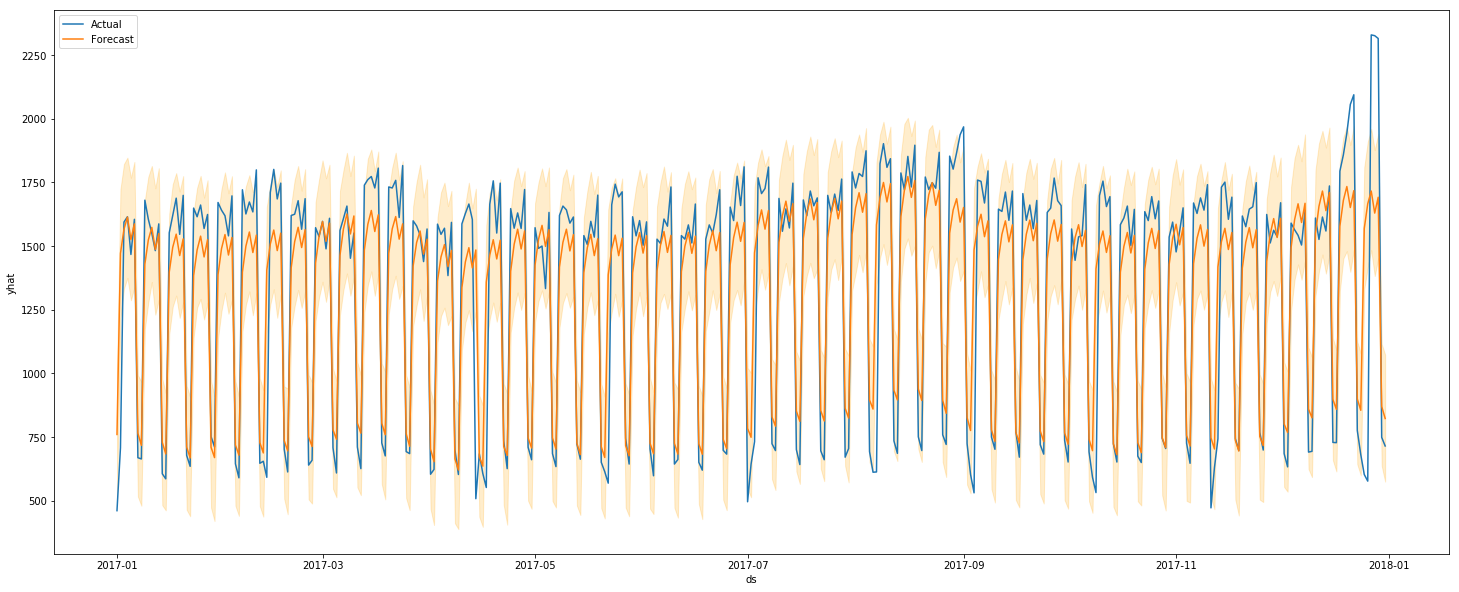

In [29]:
ax = plt.figure(figsize=(25,10))
ax = sns.lineplot(data=val_count_by_day, x="ds", y="y", label="Actual")
ax = sns.lineplot(data=forecast_val[forecast_val["ds"]>"2016-12-31"], x="ds", y="yhat", label="Forecast")
ax.fill_between(data=forecast_val[forecast_val["ds"]>"2016-12-31"], x="ds", y1='yhat_lower', y2='yhat_upper', color="orange", alpha=0.2)


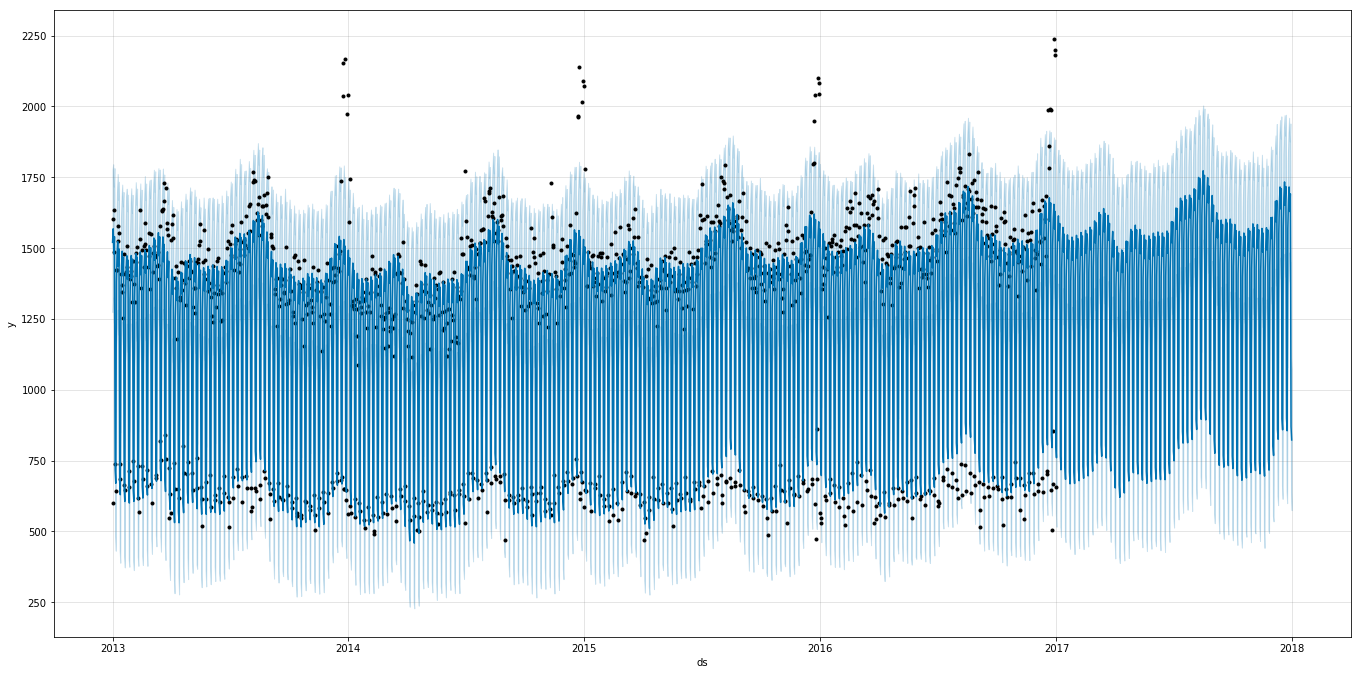

In [30]:
fig1 = m.plot(forecast_val)
fig1.set_size_inches(20, 10, forward=True)

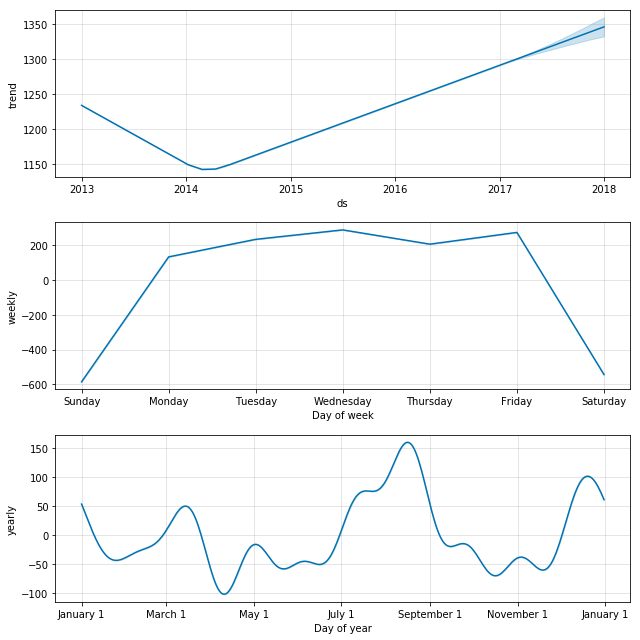

In [31]:
fig2 = m.plot_components(forecast_val)

In [151]:
# prediction & MAPE of daily
predictions_val = forecast_val[forecast_val["ds"] > "2016-12-31"]["yhat"]
mape(val_count_by_day['y'], predictions_val)

13.774219717184675

# Predictions of weekly with daily

In [18]:
# aggregated weekly predictions
predictions_val = forecast_val[forecast_val["ds"] > "2016-12-31"]
predictions_val["week"] = predictions_val["ds"].dt.weekofyear
predictions = predictions_val.groupby("week").yhat.sum().reset_index()

/Users/pokepoke4/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# aggregated weekly real data
val_count_by_day["week"] = val_count_by_day["ds"].dt.weekofyear
actual = val_count_by_day.groupby("week").y.sum().reset_index()

In [20]:
mape(actual["y"], predictions["yhat"])

4.192066216485508

# Split by EXCEPTION_GROUP

In [552]:
# make future dataframe
future_val = m.make_future_dataframe(periods=365, freq="D", include_history=False)
future_val.tail()

def run_prophet(series):
    model = Prophet(daily_seasonality=True)
    model.fit(series)
#     future = model.make_future_dataframe(periods=365, include_history=False)
    forecast = model.predict(future_val)
    return forecast

In [553]:
groups = raw_data["EXCEPTION_GROUP"].unique()
groups

array(['Move', 'Vacation', 'Leave of Absence', 'Unpaid Sick', 'Paid Sick',
       'Other', 'Vacancy', 'Workload', 'Work Related Injury', 'Swap',
       'On Call & Call Back', 'Casual Sick or Cancelled',
       'Schedule Adjustment', 'Relief Sick', 'Education'], dtype=object)

In [554]:
splitting_train = train.groupby(["EXCEPTION_GROUP", "SHIFT_DATE"]).size().reset_index()
splitting_train = splitting_train.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [555]:
warnings.simplefilter('ignore')
# create split data + run prophet for each data
split_data = []
pred_results = {}
for i in groups:
    data = splitting_train[splitting_train["EXCEPTION_GROUP"]==i].reset_index()
    split_data.append(data)
    pred_results[i] = run_prophet(data)

In [556]:
# create validation dataframes
splitting_val = val.groupby(["EXCEPTION_GROUP", "SHIFT_DATE"]).size().reset_index()
splitting_val = splitting_val.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [557]:
# get actual results
real_results = {}
for i in groups:
    data = splitting_val[splitting_val["EXCEPTION_GROUP"]==i].reset_index(drop=True)
    real_results[i] = data

In [558]:
# daily mape
mape(all_groups_real["total"], all_groups_pred["total"])

13.76826434648761

## Combining Daily to Weekly

In [559]:
# predictions combined
start = "Move"
all_groups_pred = pred_results[start][["ds","yhat"]].rename({"yhat":start}, axis=1)
all_groups_real = real_results[start][["ds","y"]].rename({"y":start}, axis=1)
for i in groups:
    if i != start:
        temp_1 = pred_results[i][["ds","yhat"]].rename({"yhat":i}, axis=1)
        temp_2 = real_results[i][["ds","y"]].rename({"y":i}, axis=1)
        all_groups_pred = pd.merge(all_groups_pred, temp_1, on="ds", how="outer")
        all_groups_real = pd.merge(all_groups_real, temp_2, on="ds", how="outer")

In [560]:
# get totals
all_groups_pred["total"] = all_groups_pred.sum(axis=1, skipna=True, numeric_only=True)
all_groups_real["total"] = all_groups_real.sum(axis=1, skipna=True, numeric_only=True)

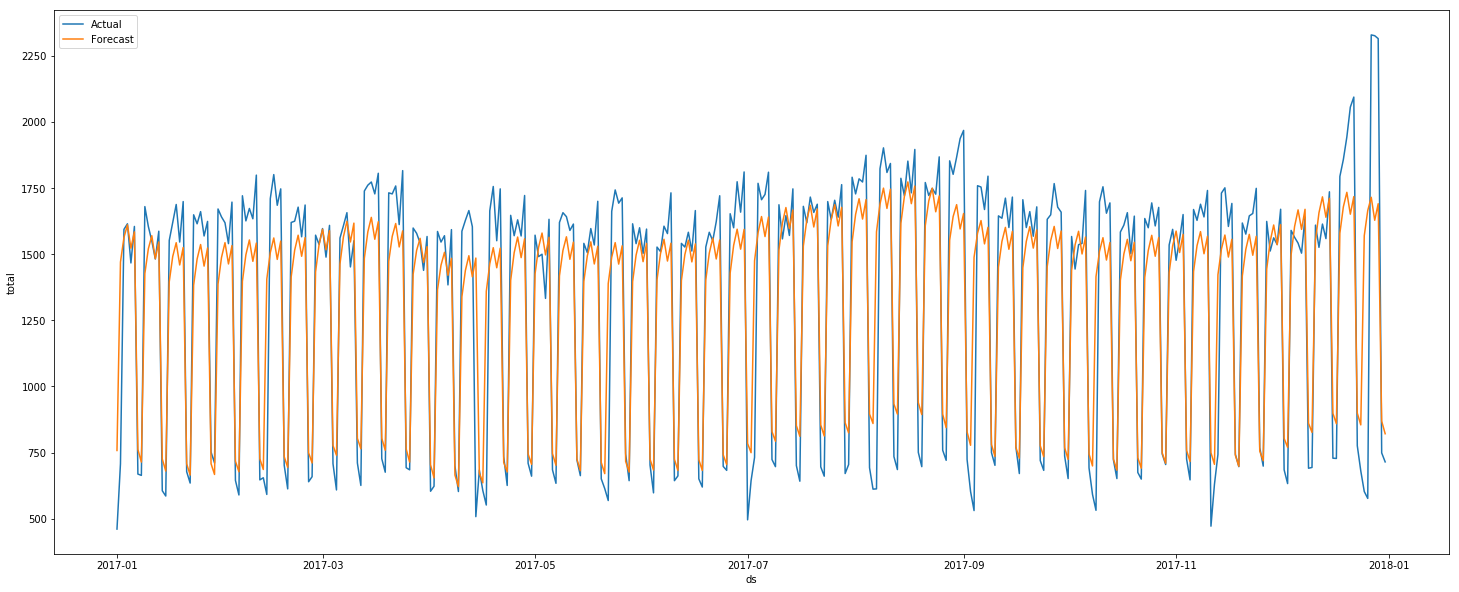

In [561]:
ax = plt.figure(figsize=(25,10))
ax = sns.lineplot(data=all_groups_real, x="ds", y="total", label="Actual")
ax = sns.lineplot(data=all_groups_pred[all_groups_pred["ds"]>"2016-12-31"], x="ds", y="total", label="Forecast")


In [562]:
# make weekly
weekly_by_group = pd.merge(all_groups_real, all_groups_pred, on="ds", suffixes=("_real", "_pred"))[["ds", "total_real", "total_pred"]]
weekly_by_group["week"] = weekly_by_group["ds"].dt.weekofyear
weekly_real = weekly_by_group.groupby("week").total_real.sum().reset_index()
weekly_pred = weekly_by_group.groupby("week").total_pred.sum().reset_index()

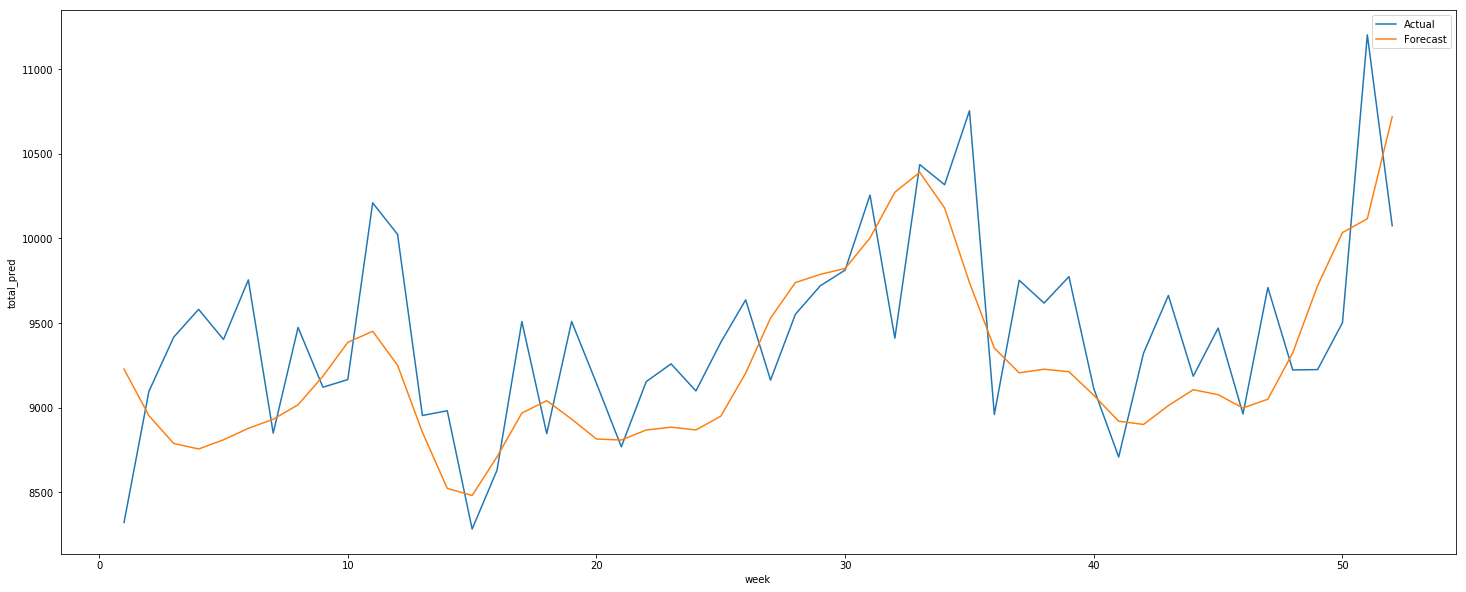

In [563]:
# weekly plot
ax = plt.figure(figsize=(25,10))
ax = sns.lineplot(data=weekly_real, x="week", y="total_real", label="Actual")
ax = sns.lineplot(data=weekly_pred, x="week", y="total_pred", label="Forecast")


In [564]:
# MAPE for weekly aggregated number VIA splitting by EXCEPTION_GROUP
mape(weekly_real["total_real"], weekly_pred["total_pred"])

4.1773945240792205

## Individual daily MAPES via EXCEPTION_GROUP

In [370]:
# combine predictions and real - MAPE
mapes = {}
for i in groups:
    combined = pd.merge(real_results[i],
                        pred_results[i], on="ds", how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]
    mapes[i] = mape(combined["y"], combined["yhat"])
    
# individual mapes for each group "daily" is not so good
mapes

{'Move': 44.056663403577986,
 'Vacation': 50.775627659285625,
 'Leave of Absence': 27.45644832314153,
 'Unpaid Sick': 31.728261318637486,
 'Paid Sick': 31.634172040851478,
 'Other': 22.687855858159185,
 'Vacancy': 11.286687865575908,
 'Workload': 31.796231599414465,
 'Work Related Injury': 62.33979509549129,
 'Swap': 10.161141923107403,
 'On Call & Call Back': 34.29670773182551,
 'Casual Sick or Cancelled': 29.681742537246535,
 'Schedule Adjustment': 39.79842033941415,
 'Relief Sick': 79.97759406911017,
 'Education': 162.50960204880923}

# Split by SITE and LABOR AGREEMENT
# IMPORTANT!!!!

### Not a function yet... Will work on that

# Method 1

In [1013]:
# using only a portion of the sites
small_train = train[(train["SITE"]=="St Paul's Hospital") | 
                    (train["SITE"]=="Mt St Joseph") | 
                    (train["SITE"]=="Holy Family") | 
                    (train["SITE"]=="SVH Langara") | 
                    (train["SITE"]=="PCH Corporate") | 
                    (train["SITE"]=="Brock Fahrni") | 
                    (train["SITE"]=="Youville Residence")]
# small_train = small_train[(small_train["EXCEPTION_GROUP"] != "Education") &
#                           (small_train["EXCEPTION_GROUP"] != "Swap")]

small_val = val[(val["SITE"]=="St Paul's Hospital") | 
                (val["SITE"]=="Mt St Joseph") | 
                (val["SITE"]=="Holy Family") | 
                (val["SITE"]=="SVH Langara") | 
                (val["SITE"]=="PCH Corporate") | 
                (val["SITE"]=="Brock Fahrni") | 
                (val["SITE"]=="Youville Residence")]
# small_val = small_val[(small_val["EXCEPTION_GROUP"] != "Education") &
#                       (small_val["EXCEPTION_GROUP"] != "Swap")]

In [1014]:
# create training dataframes
splitting_train = small_train.groupby(["LABOR_AGREEMENT", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_train = splitting_train.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

# create validation dataframes
splitting_val = small_val.groupby(["LABOR_AGREEMENT", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_val = splitting_val.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [1015]:
# create timeframe data for prediction
timeframe = pd.DataFrame(pd.date_range(start='2017-01-02', end='2017-12-31', freq="D")).rename({0:"ds"}, axis=1)

In [1016]:
def run_prophet(series, timeframe=timeframe):
    model = Prophet(daily_seasonality=True)
    model.fit(series)
    forecast = model.predict(timeframe)
    return forecast

In [1017]:
# removing "EXCL" due to technical difficulties
small_sites = small_train["SITE"].unique()
# small_las = ["NURS", "FAC", "COM", "PARMED", }"EXCL"]
small_las = ["NURS", "FAC", "COM", "PARMED"]

In [1018]:
# create and store predictions and true results
split_data = {}
pred_results = {}
true_results = {}
for i in small_sites:
    for j in small_las:
        temp_data_train = splitting_train[(splitting_train["SITE"]==i) & (splitting_train["LABOR_AGREEMENT"]==j)].reset_index()
        temp_data_val = splitting_val[(splitting_val["SITE"]==i) & (splitting_val["LABOR_AGREEMENT"]==j)].reset_index(drop=True)
        split_data[(i, j)] = temp_data_train
        true_results[(i, j)] = temp_data_val
        try:
            pred_results[(i, j)] = run_prophet(temp_data_train)
            print("Fitting", i, j, ": Done")
        except ValueError:
            pred_results[(i, j)] = None
            print("Fitting", i, j, ": Failed")

Fitting St Paul's Hospital NURS : Done
Fitting St Paul's Hospital FAC : Done
Fitting St Paul's Hospital COM : Done
Fitting St Paul's Hospital PARMED : Done
Fitting Mt St Joseph NURS : Done
Fitting Mt St Joseph FAC : Done
Fitting Mt St Joseph COM : Failed
Fitting Mt St Joseph PARMED : Done
Fitting Youville Residence NURS : Done
Fitting Youville Residence FAC : Done
Fitting Youville Residence COM : Failed
Fitting Youville Residence PARMED : Done
Fitting SVH Langara NURS : Done
Fitting SVH Langara FAC : Done
Fitting SVH Langara COM : Failed
Fitting SVH Langara PARMED : Done
Fitting Brock Fahrni NURS : Done
Fitting Brock Fahrni FAC : Done
Fitting Brock Fahrni COM : Failed
Fitting Brock Fahrni PARMED : Done
Fitting Holy Family NURS : Done
Fitting Holy Family FAC : Done
Fitting Holy Family COM : Failed
Fitting Holy Family PARMED : Done


In [1019]:
# combine predictions and true results
combined = {}
for i in true_results:
    if pred_results[i] is not None:
        combined[i] = pd.merge(true_results[i], 
                               pred_results[i], 
                               on="ds", 
                               how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]

In [1020]:
# calculate daily MAPE for each group
for i in combined:
    print(i, end=": ")
    print(mape(combined[i]["y"], combined[i]["yhat"]))

("St Paul's Hospital", 'NURS'): 9.289000815304496
("St Paul's Hospital", 'FAC'): 15.99162388128149
("St Paul's Hospital", 'COM'): 79.96841502713607
("St Paul's Hospital", 'PARMED'): 30.149823250063495
('Mt St Joseph', 'NURS'): 25.785549734057835
('Mt St Joseph', 'FAC'): 21.637058934116364
('Mt St Joseph', 'PARMED'): 29.5244643661965
('Youville Residence', 'NURS'): 37.4567468038201
('Youville Residence', 'FAC'): 24.073429693334806
('Youville Residence', 'PARMED'): 40.45416345623544
('SVH Langara', 'NURS'): 38.29144052001717
('SVH Langara', 'FAC'): 15.009544209839298
('SVH Langara', 'PARMED'): 61.30007274137957
('Brock Fahrni', 'NURS'): 40.13265706106481
('Brock Fahrni', 'FAC'): 21.248296631893222
('Brock Fahrni', 'PARMED'): 41.12508909636025
('Holy Family', 'NURS'): 25.82306489028466
('Holy Family', 'FAC'): 18.834515518896517
('Holy Family', 'PARMED'): 63.902382532669456


In [1025]:
# convert to week and calculating MAPE weekly
weekly = {}
for i in combined:
    # create week column
    combined[i]["week"] = combined[i]["ds"].dt.week
    combined[i]["date"] = combined[i]["ds"]-pd.DateOffset(weekday=0, weeks=1)
    
    weekly_y = combined[i].groupby("date").y.sum().reset_index()
    weekly_yhat = combined[i].groupby("date").yhat.sum().reset_index()
    weekly_yhat_lower = combined[i].groupby("date").yhat_lower.sum().reset_index()
    weekly_yhat_upper = combined[i].groupby("date").yhat_upper.sum().reset_index()
    
    # merge weekly results
    weekly[i] = pd.concat([weekly_y, weekly_yhat["yhat"], 
                           weekly_yhat_lower["yhat_lower"], 
                           weekly_yhat_upper["yhat_upper"]], 
                          axis=1)

    # create repeating columns "year", "site", "labor_agreement"
    length = weekly[i].shape[0]
    weekly[i]["week"] = weekly[i]["date"].dt.weekofyear
    weekly[i]["site"] = np.repeat(i[0], length)
    weekly[i]["labor_agreement"] = np.repeat(i[1], length)
    
    print(i, end=": ")
    print(mape(weekly[i]["y"], weekly[i]["yhat"]))

("St Paul's Hospital", 'NURS'): 5.13187234231843
("St Paul's Hospital", 'FAC'): 10.254556594186036
("St Paul's Hospital", 'COM'): 39.222951732366774
("St Paul's Hospital", 'PARMED'): 11.052259107599271
('Mt St Joseph', 'NURS'): 13.053194405254873
('Mt St Joseph', 'FAC'): 15.054558339159573
('Mt St Joseph', 'PARMED'): 14.48338550910828
('Youville Residence', 'NURS'): 17.567530652529374
('Youville Residence', 'FAC'): 16.97423731263223
('Youville Residence', 'PARMED'): 39.43236299263334
('SVH Langara', 'NURS'): 21.36100676426401
('SVH Langara', 'FAC'): 9.000432633471856
('SVH Langara', 'PARMED'): 56.077350619127046
('Brock Fahrni', 'NURS'): 23.076409005588975
('Brock Fahrni', 'FAC'): 13.527104384845309
('Brock Fahrni', 'PARMED'): inf
('Holy Family', 'NURS'): 15.633298290180289
('Holy Family', 'FAC'): 10.59470359536649
('Holy Family', 'PARMED'): inf


# Imagine I am trying to see the accuracy for Nurses (among all SITEs)

In [1026]:
def aggregate_mape(data, variable):
    test_pred = timeframe.copy()
    test_true = timeframe.copy()
    for i in combined:
        if variable in i:
            test_pred = pd.merge(test_pred, data[i][["ds", "yhat"]], on="ds")
            test_true = pd.merge(test_true, data[i][["ds", "y"]], on="ds")
    sum_pred = test_pred.sum(axis=1)
    sum_true = test_true.sum(axis=1)
    return mape(sum_true, sum_pred)

In [1027]:
# can change var to any SITE or LABOR_AGREEMENT
for i in small_sites:
    print(i, end=": ")
    print(aggregate_mape(combined, i))

St Paul's Hospital: 10.068908469409159
Mt St Joseph: 15.103363814364007
Youville Residence: 21.071150700391534
SVH Langara: 14.446872665023566
Brock Fahrni: 19.142664228199738
Holy Family: 18.137530625576073


In [1028]:
for i in small_las:
    print(i, end=": ")
    print(aggregate_mape(combined, i))

NURS: 9.628321334888984
FAC: 12.593533271797943
COM: 79.96841502713609
PARMED: 34.44070194089715


# Run below code to export tables

In [1029]:
# export to "data/predictions/" directory
for i, j in weekly:
    weekly[(i,j)].to_csv("../data/predictions/{}_{}.csv".format(i,j))

# Method 2
# Another way of grouping weekly

In [889]:
# Use train['ds']-pd.DateOffset(weekday=0, weeks=1)

### Not done yet

In [865]:
# convert to week and calculating MAPE weekly
weekly = {}
for i in combined:
    # create week column
    combined[i]["ds"] = combined[i]['ds']-pd.DateOffset(weekday=0, weeks=1)
    weekly_real = combined[i].groupby("ds").y.sum().reset_index()
    weekly_pred = combined[i].groupby("ds").yhat.sum().reset_index()
    
    # merge weekly results
    weekly[i] = pd.merge(weekly_real, weekly_pred, on="ds")
    
    # create repeating columns "year", "site", "labor_agreement"
    length = weekly[i].shape[0]
    weekly[i]["year"] = np.repeat(2017, length)
    weekly[i]["site"] = np.repeat(i[0], length)
    weekly[i]["labor_agreement"] = np.repeat(i[1], length)
    
    print(i, end=": ")
    print(mape(weekly[i]["y"], weekly[i]["yhat"]))

("St Paul's Hospital", 'NURS'): 4.56247414009031
("St Paul's Hospital", 'FAC'): 10.360615604027904
("St Paul's Hospital", 'COM'): 42.511250698074825
("St Paul's Hospital", 'PARMED'): 9.72782620769934
('Mt St Joseph', 'NURS'): 13.73385460345514
('Mt St Joseph', 'FAC'): 16.30003140261152
('Mt St Joseph', 'PARMED'): 14.85243179264514
('Youville Residence', 'NURS'): 18.165730338397093
('Youville Residence', 'FAC'): 15.558637153643264
('Youville Residence', 'PARMED'): inf
('SVH Langara', 'NURS'): 21.51594194770421
('SVH Langara', 'FAC'): 8.578972160573272
('SVH Langara', 'PARMED'): inf
('Brock Fahrni', 'NURS'): 27.35114771671886
('Brock Fahrni', 'FAC'): 13.863103889313127
('Brock Fahrni', 'PARMED'): inf
('Holy Family', 'NURS'): 16.12470051688943
('Holy Family', 'FAC'): 11.832994805631143
('Holy Family', 'PARMED'): inf


# Sorry, but please ignore below for now.

# Below is irrelevant
### Only one site

In [425]:
# split data to St Paul
site = "Mt St Joseph"
stpaul_train = train[train["SITE"]==site]
stpaul_val = val[val["SITE"]==site]

In [428]:
splitting_sp_train = stpaul_train.groupby(["EXCEPTION_GROUP", "SHIFT_DATE"]).size().reset_index()
splitting_sp_train = splitting_sp_train.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [429]:
warnings.simplefilter('ignore')
# create split data + run prophet for each data
split_data = []
pred_results = {}
for i in groups:
    data = splitting_sp_train[splitting_sp_train["EXCEPTION_GROUP"]==i].reset_index()
    split_data.append(data)
    pred_results[i] = run_prophet(data)

In [430]:
# create validation dataframes
splitting_sp_val = stpaul_val.groupby(["EXCEPTION_GROUP", "SHIFT_DATE"]).size().reset_index()
splitting_sp_val = splitting_sp_val.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [431]:
# get actual results
real_results = {}
for i in groups:
    data = splitting_sp_val[splitting_sp_val["EXCEPTION_GROUP"]==i].reset_index(drop=True)
    real_results[i] = data

In [432]:
# predictions combined
start = "Move"
all_groups_pred = pred_results[start][["ds","yhat"]].rename({"yhat":start}, axis=1)
all_groups_real = real_results[start][["ds","y"]].rename({"y":start}, axis=1)
for i in groups:
    if i != start:
        temp_1 = pred_results[i][["ds","yhat"]].rename({"yhat":i}, axis=1)
        temp_2 = real_results[i][["ds","y"]].rename({"y":i}, axis=1)
        all_groups_pred = pd.merge(all_groups_pred, temp_1, on="ds", how="outer")
        all_groups_real = pd.merge(all_groups_real, temp_2, on="ds", how="outer")

In [433]:
# get totals
all_groups_pred["total"] = all_groups_pred.sum(axis=1, skipna=True, numeric_only=True)
all_groups_real["total"] = all_groups_real.sum(axis=1, skipna=True, numeric_only=True)

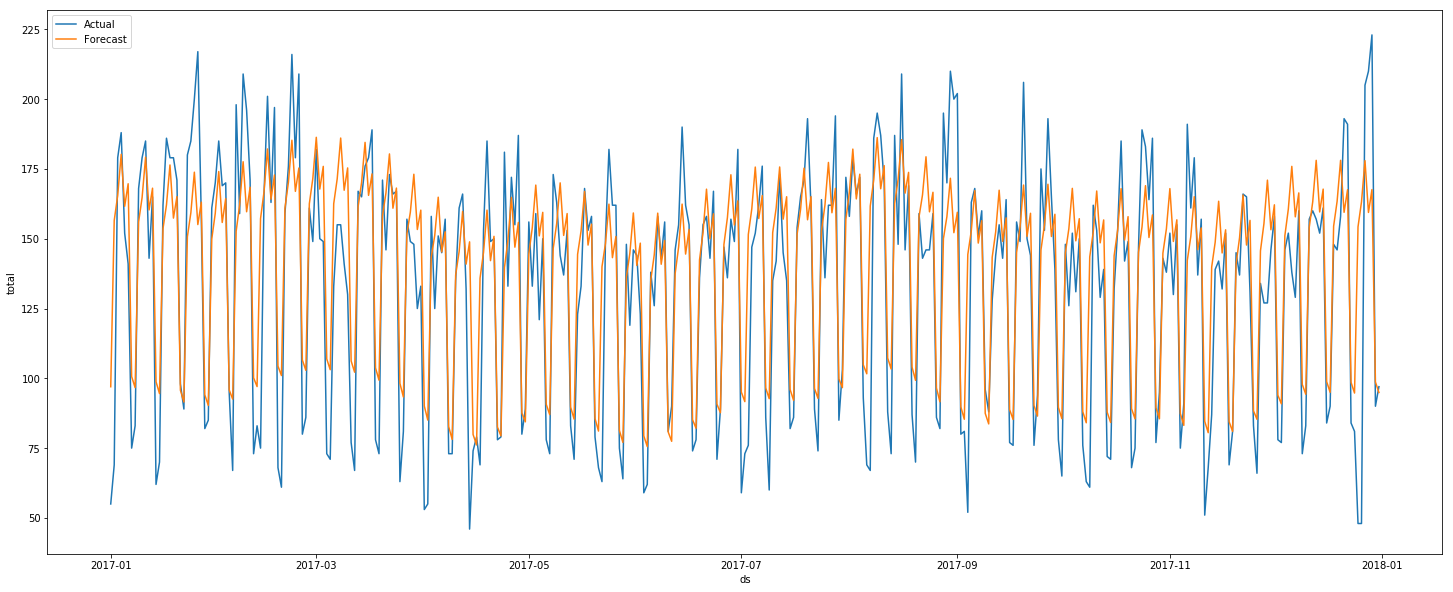

In [434]:
ax = plt.figure(figsize=(25,10))
ax = sns.lineplot(data=all_groups_real, x="ds", y="total", label="Actual")
ax = sns.lineplot(data=all_groups_pred[all_groups_pred["ds"]>"2016-12-31"], x="ds", y="total", label="Forecast")


In [435]:
# make weekly
weekly_by_group = pd.merge(all_groups_real, all_groups_pred, on="ds", suffixes=("_real", "_pred"))[["ds", "total_real", "total_pred"]]
weekly_by_group["week"] = weekly_by_group["ds"].dt.weekofyear
weekly_real = weekly_by_group.groupby("week").total_real.sum().reset_index()
weekly_pred = weekly_by_group.groupby("week").total_pred.sum().reset_index()

In [436]:
# MAPE for weekly aggregated number VIA splitting by EXCEPTION_GROUP
mape(weekly_real["total_real"], weekly_pred["total_pred"])

8.151048603873651

In [565]:
# combine predictions and real - MAPE
mapes = {}
for i in groups:
    combined = pd.merge(real_results[i],
                        pred_results[i], on="ds", how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]
    mapes[i] = mape(combined["y"], combined["yhat"])
    
# individual mapes for each group "daily" is not so good
mapes

{'Move': 44.056663403577986,
 'Vacation': 50.775627659285625,
 'Leave of Absence': 27.45644832314153,
 'Unpaid Sick': 31.728261318637486,
 'Paid Sick': 31.634172040851478,
 'Other': 22.687855858159185,
 'Vacancy': 11.286687865575908,
 'Workload': 31.796231599414465,
 'Work Related Injury': 62.33979509549129,
 'Swap': 10.161141923107403,
 'On Call & Call Back': 34.29670773182551,
 'Casual Sick or Cancelled': 29.681742537246535,
 'Schedule Adjustment': 39.79842033941415,
 'Relief Sick': 79.97759406911017,
 'Education': 162.50960204880923}

In [575]:
# combine predictions and real - MAPE
mapes_weekly = {}
for i in groups:
    combined = pd.merge(real_results[i],
                        pred_results[i], on="ds", how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]
    combined["week"] = combined["ds"].dt.weekofyear
    combined_true = combined.groupby("week").y.sum().reset_index()
    combined_pred = combined.groupby("week").yhat.sum().reset_index()
    mapes_weekly[i] = mape(combined_true["y"], combined_pred["yhat"])
    
# individual mapes for each group "weekly" is okay
mapes_weekly

{'Move': 15.383781666215313,
 'Vacation': 12.922222812969173,
 'Leave of Absence': 11.94607104044428,
 'Unpaid Sick': 21.642177661634594,
 'Paid Sick': 8.519603957704147,
 'Other': 7.0832828133441925,
 'Vacancy': 7.427847506445907,
 'Workload': 25.53134551234657,
 'Work Related Injury': 29.528409953205298,
 'Swap': 6.187175999910751,
 'On Call & Call Back': 24.47381352624391,
 'Casual Sick or Cancelled': 11.148225861114911,
 'Schedule Adjustment': 20.270108488026782,
 'Relief Sick': 25.705314626336666,
 'Education': 47.89379528468094}

# Creating a function for the above process

In [581]:
# make future dataframe
# future_val = m.make_future_dataframe(periods=365, freq="D", include_history=False)
timeframe = pd.DataFrame(pd.date_range(start='2017-01-01', end='2017-12-31', freq="D")).rename({0:"ds"}, axis=1)

def run_prophet(series, timeframe=timeframe):
    model = Prophet(daily_seasonality=True)
    model.fit(series)
    # future = model.make_future_dataframe(periods=365, include_history=False)
    forecast = model.predict(timeframe)
    return forecast

# exception_group groups
groups = raw_data["EXCEPTION_GROUP"].unique()

In [498]:
def prophet_by_exception(train, val, weekly=False):
    # create training dataframes
    splitting_train = train.groupby(["EXCEPTION_GROUP", "SHIFT_DATE"]).size().reset_index()
    splitting_train = splitting_train.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)
    
    # create validation dataframes
    splitting_val = val.groupby(["EXCEPTION_GROUP", "SHIFT_DATE"]).size().reset_index()
    splitting_val = splitting_val.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)
    
    # warnings.simplefilter('ignore')
    # create split data + run prophet for each data
    split_data = []
    pred_results = {}
    for i in groups:
        data = splitting_train[splitting_train["EXCEPTION_GROUP"]==i].reset_index()
        split_data.append(data)
        pred_results[i] = run_prophet(data)
    
    # get true results
    true_results = {}
    for i in groups:
        data = splitting_val[splitting_val["EXCEPTION_GROUP"]==i].reset_index(drop=True)
        true_results[i] = data
        
    # predictions and true results combined
    start = "Move"
    all_groups_pred = pred_results[start][["ds","yhat"]].rename({"yhat":start}, axis=1)
    all_groups_true = true_results[start][["ds","y"]].rename({"y":start}, axis=1)
    for i in groups:
        if i != start:
            temp_1 = pred_results[i][["ds","yhat"]].rename({"yhat":i}, axis=1)
            temp_2 = true_results[i][["ds","y"]].rename({"y":i}, axis=1)
            all_groups_pred = pd.merge(all_groups_pred, temp_1, on="ds", how="outer")
            all_groups_true = pd.merge(all_groups_true, temp_2, on="ds", how="outer")
            
    # get totals for predictions and true
    all_groups_pred["total"] = all_groups_pred.sum(axis=1, skipna=True, numeric_only=True)
    all_groups_true["total"] = all_groups_true.sum(axis=1, skipna=True, numeric_only=True)
    
    if weekly:
        # make weekly dataframe
        weekly_by_group = pd.merge(all_groups_true, all_groups_pred, on="ds", suffixes=("_true", "_pred"))[["ds", "total_true", "total_pred"]]
        weekly_by_group["week"] = weekly_by_group["ds"].dt.weekofyear
        weekly_real = weekly_by_group.groupby("week").total_true.sum().reset_index().rename({"total_true":"total"}, axis=1)
        weekly_pred = weekly_by_group.groupby("week").total_pred.sum().reset_index().rename({"total_pred":"total"}, axis=1)
        return weekly_real, weekly_pred
    
    return all_groups_true, all_groups_pred
